In [40]:
import deepxde as dde

import numpy as np
import torch

import copy
import matplotlib.pyplot as plt
import seaborn as sns

'''
Based on these reference codes
[1] Lid-driven cavity problem: https://github.com/i207M/PINNacle/blob/595ab6898a30d27ac6cd44ff0a465482f8c52f5c/src/pde/ns.py
[2] Visualization: https://github.com/lululxvi/deepxde/issues/634
'''
dde.config.set_random_seed(42)

# PDE
def liddriven_pde(x, u):
    nu = 0.01
    u_vel, v_vel, _ = u[:, [0]], u[:, [1]], u[:, [2]]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (u_vel * u_vel_x + v_vel * u_vel_y + p_x - nu * (u_vel_xx + u_vel_yy))
    momentum_y = (u_vel * v_vel_x + v_vel * v_vel_y + p_y - nu * (v_vel_xx + v_vel_yy))
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

# Geometry
bbox=[0, 1, 0, 1]
geom = dde.geometry.Rectangle(xmin=[bbox[0], bbox[2]], xmax=[bbox[1], bbox[3]])

# BC
def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], bbox[3])

def boundary_not_top(x, on_boundary):
    return on_boundary and not np.isclose(x[1], bbox[3])

bc_top_u = dde.DirichletBC(geom, (lambda _: 1), boundary_top, component=0)
bc_top_v = dde.DirichletBC(geom, (lambda _: 0), boundary_top, component=1)
bc_wall_u = dde.DirichletBC(geom, (lambda _: 0), boundary_not_top, component=0)
bc_wall_v = dde.DirichletBC(geom, (lambda _: 0), boundary_not_top, component=1)
bcs = [bc_top_u, bc_top_v, bc_wall_u, bc_wall_v]
# bcs = [bc_wall_u, bc_wall_v]

# Data
data = dde.data.PDE(geom, liddriven_pde, bcs, num_domain=1000, num_boundary=400, num_test=5000, train_distribution='Hammersley')

# Model
layer_size = [2] + [20]*5 + [3]
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN(layer_size, activation, initializer)

# Hard-constraints
# def output_transform(x, u):
#     '''
#     Hard-constraints are imposed only on the top plane
#     : when y=1 -> u=1 & v=0
#     '''
#     u_x = u[:, [0]] * (x[:, [1]] - 1) + 1
#     u_v = u[:, [1]] * (x[:, [1]] - 1)
#     return torch.concat((u_x, u_v, u[:,[2]]), axis=1)
#
# net.apply_output_transform(output_transform)

# Compile & Train - ADAM
'''
For more options: https://deepxde.readthedocs.io/en/latest/modules/deepxde.html#module-deepxde.model
'''
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations = 10000, display_every = 100, model_save_path = './')
# dde.saveplot(losshistory, train_state, issave = True, isplot = True)

# Compile & Train - L-BFGS-B
model.compile(optimizer = 'L-BFGS-B')
losshistory, train_state = model.train(display_every = 100, model_save_path = './')

Compiling model...
'compile' took 0.000086 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [4.55e-02, 1.82e-01, 1.91e-01, 1.34e+00, 1.83e-01, 1.02e-01, 1.28e-01]    [4.58e-02, 1.82e-01, 1.97e-01, 1.34e+00, 1.83e-01, 1.02e-01, 1.28e-01]    []  
100       [7.66e-04, 1.15e-04, 3.61e-03, 3.41e-02, 1.21e-04, 1.40e-01, 7.88e-05]    [6.18e-04, 1.08e-04, 3.04e-03, 3.41e-02, 1.21e-04, 1.40e-01, 7.88e-05]    []  
200       [9.24e-04, 2.51e-04, 3.41e-03, 3.18e-02, 1.39e-04, 1.33e-01, 1.69e-04]    [7.38e-04, 2.28e-04, 2.88e-03, 3.18e-02, 1.39e-04, 1.33e-01, 1.69e-04]    []  
300       [9.96e-04, 5.25e-04, 3.59e-03, 2.93e-02, 2.36e-04, 1.28e-01, 3.15e-04]    [7.83e-04, 4.68e-04, 3.03e-03, 2.93e-02, 2.36e-04, 1.28e-01, 3.15e-04]    []  
400       [9.94e-04, 7.97e-04, 3.61e-03, 2.64e-02, 3.67e-04, 1.21e-01, 5.06e-04]    [7.62e-04, 7.09e-04, 3.02e-03

In [314]:
def divide_data(data):
    """
    Divide data into bc & collocation pts
    :param data: dde.data object to be used for obtaining collocation points
    :return: bc points & collocation points
    """
    num_bc_pts = data.train_x_bc.shape[0]
    bc_pts = data.train_x[:num_bc_pts]
    collocation_pts = data.train_x[num_bc_pts:]
    return bc_pts, collocation_pts

def update_collocation(model, data, N_adapt=100, criterion="v"):
    """
    Update only collocation points of the given data (bc points do not change)
    :param data: dde.data object to be used for adaptive sampling
    :param anchors: collocation points to be newly added to the previous bc points
    :return: updated data
    """

    def get_new_collocation(model, eval_pts, N_adapt=100, criterion="v"):
        """
        Extract top num_extraction points w.r.t. vorticity magnitude among collocation points
        :param model: trained model used for evaluating vorticity
        :param eval_pts: location of the points used for evaluating vorticity
        :param N_adapt: number of points to be extracted w.r.t. vorticity magnitude
        :return: new set of collocation points (newly sampled collcoation pts + high vorticity magnitude pts)
        """
        def evaluate_vorticity(x, u):
            du_dy = dde.grad.jacobian(u, x, i=0, j=1)
            dv_dx = dde.grad.jacobian(u, x, i=1, j=0)
            return torch.abs(du_dy - dv_dx)

        def evaluate_advP(x, u):
            dP_dx = dde.grad.jacobian(u, x, i=2, j=0)
            return dP_dx

        if criterion=="v":
            y_evaluated = model.predict(eval_pts, operator=evaluate_vorticity).reshape(-1)
            sorted_indices = np.argsort(y_evaluated)[::-1]
        elif criterion=="p":
            y_evaluated = model.predict(eval_pts, operator=evaluate_advP).reshape(-1)
            sorted_indices = np.argsort(y_evaluated)[::-1]
        elif criterion=="both":
            y_evaluated_v = model.predict(eval_pts, operator=evaluate_vorticity).reshape(-1)
            sorted_indices_v = np.argsort(y_evaluated_v)[::-1]
            y_evaluated_p = model.predict(eval_pts, operator=evaluate_advP).reshape(-1)
            sorted_indices_p = np.argsort(y_evaluated_p)[::-1]
            # Index: vorticity first, then advP is added
            sorted_indices = np.concatenate((sorted_indices_v[:int(N_adapt/2)], sorted_indices_p[:N_adapt-int(N_adapt/2)]))
        new_adapt = eval_pts[sorted_indices][:N_adapt]

        new_even = dde.data.PDE(data.geom, pde=None, bcs=[], num_domain=eval_pts.shape[0]-N_adapt, train_distribution='LHS')
        new_even = new_even.train_x_all

        return np.vstack((new_even, new_adapt))

    past_bc_pts, past_collocation_pts = divide_data(data)
    new_bc_pts = past_bc_pts

    if True:
        # 새롭게 샘플링된 pts를 사용하여 vorticity evaluation
        eval_pts = dde.data.PDE(data.geom, pde=None, bcs=[],
                                num_domain=past_collocation_pts.shape[0],
                                train_distribution='LHS').train_x_all
    else:
        # 이전 iteration의 collocation pts를 사용하여 vorticity evaluation
        eval_pts = past_collocation_pts
    new_collocation_pts = get_new_collocation(model, eval_pts, N_adapt=N_adapt, criterion=criterion)

    new_train_x = np.vstack((new_bc_pts, new_collocation_pts))

    data.train_x = new_train_x

def plot_pts(data, N_adapt=100, tag="0"):

    past_x = data.train_x[:-N_adapt][:,0]
    past_y = data.train_x[:-N_adapt][:,1]

    added_x = data.train_x[-N_adapt:][:,0]
    added_y = data.train_x[-N_adapt:][:,1]

    fig, ax = plt.subplots(dpi=150)
    ax.scatter(past_x, past_y, alpha=0.5, color='k', label="Even collocation points")
    ax.scatter(added_x, added_y, alpha=0.7, color='r', label="Vorticity-aware collocation points")
    ax.legend(fontsize=15, loc='lower right', frameon=True)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    fig.savefig(f"./fig/Iteration_{tag}")
    # plt.show()

def plot_flowfield(x1, x2, y1, y2, qoi_name=["U_x","U_y"],tag='Vanilla', stream=True):
    y1 = y1.reshape(len(x2), len(x1))
    y2 = y2.reshape(len(x2), len(x1))
    fig, ax = plt.subplots(dpi=150)
    if stream:
        ax.streamplot(x1, x2, y1, y2, density=1.5, linewidth=0.7, color='w', arrowsize=0.7, broken_streamlines=True)
    img = ax.contourf(x1, x2, y1, levels = np.linspace(-0.2, 1., 100), cmap=sns.color_palette("icefire", as_cmap=True), extend='both')
    fig.colorbar(img, ticks=np.linspace(img.levels.min(),img.levels.max(),6))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(f"${qoi_name[0]} [m/s]$", fontsize=13)
    if stream:
        fig.savefig(f"./fig/{qoi_name[0]}_{tag}_stream")
    else:
        fig.savefig(f"./fig/{qoi_name[0]}_{tag}")
    # plt.show()

    fig, ax = plt.subplots(dpi=150)
    if stream:
        ax.streamplot(x1, x2, y1, y2, density=1.5, linewidth=0.7, color='w', arrowsize=0.7, broken_streamlines=True)
    img = ax.contourf(x1, x2, y2, levels = np.linspace(-0.5, .3, 100), cmap=sns.color_palette("icefire", as_cmap=True), extend='both')
    fig.colorbar(img, ticks=np.linspace(img.levels.min(),img.levels.max(),6))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(f"${qoi_name[1]} [m/s]$", fontsize=13)
    if stream:
        fig.savefig(f"./fig/{qoi_name[1]}_{tag}_stream")
    else:
        fig.savefig(f"./fig/{qoi_name[1]}_{tag}")
    # plt.show()

Compiling model...
'compile' took 0.000274 s

Training model...

0         [2.73e-01, 6.98e-01, 9.85e-02, 1.05e+00, 2.06e-01, 5.30e-03, 1.17e-01]    [2.78e-01, 7.20e-01, 9.87e-02, 1.05e+00, 2.06e-01, 5.30e-03, 1.17e-01]    []  
100       [8.75e-04, 5.65e-04, 5.45e-03, 3.60e-02, 1.56e-04, 1.37e-01, 2.74e-04]    [8.41e-04, 5.74e-04, 5.34e-03, 3.60e-02, 1.56e-04, 1.37e-01, 2.74e-04]    []  
200       [6.57e-04, 4.08e-04, 3.71e-03, 3.06e-02, 3.05e-05, 1.32e-01, 2.72e-04]    [5.85e-04, 3.93e-04, 3.50e-03, 3.06e-02, 3.05e-05, 1.32e-01, 2.72e-04]    []  
300       [6.29e-04, 3.51e-04, 3.52e-03, 2.77e-02, 6.22e-06, 1.25e-01, 3.39e-04]    [5.34e-04, 3.21e-04, 3.23e-03, 2.77e-02, 6.22e-06, 1.25e-01, 3.39e-04]    []  
400       [6.26e-04, 3.53e-04, 3.32e-03, 2.46e-02, 6.11e-05, 1.17e-01, 4.65e-04]    [5.11e-04, 3.12e-04, 2.93e-03, 2.46e-02, 6.11e-05, 1.17e-01, 4.65e-04]    []  
500       [6.69e-04, 4.71e-04, 3.09e-03, 1.94e-02, 2.84e-04, 9.89e-02, 6.32e-04]    [5.18e-04, 4.16e-04, 2.49e-03, 1.94e

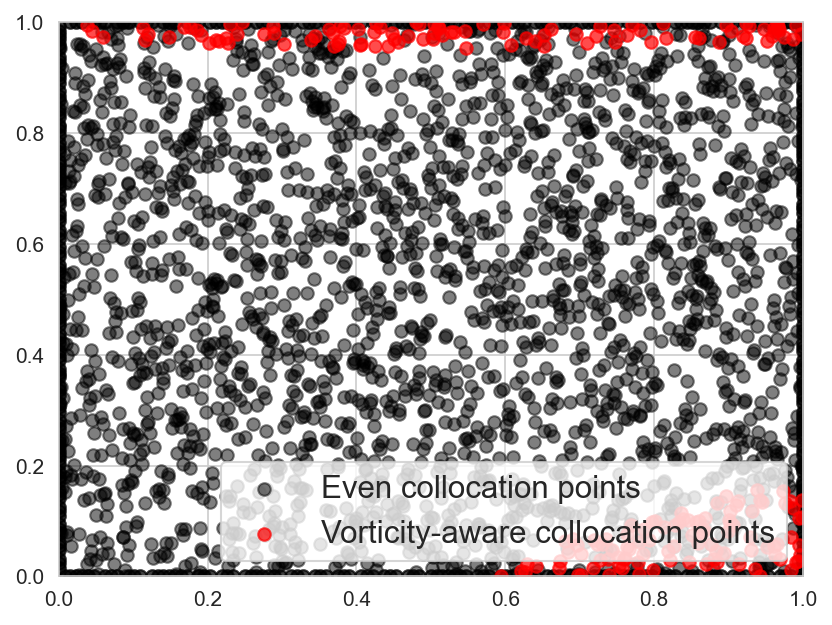

In [311]:
# VA Model
net_VA = dde.nn.FNN(layer_size, activation, initializer)

# Compile & Train - ADAM
data_VA = copy.deepcopy(data)
model_VA = dde.Model(data_VA, net_VA)
model_VA.compile("adam", lr=1e-3)
losshistory, train_state = model_VA.train(iterations = 1000, display_every = 100, model_save_path = './')

# Implement VA algorithm
N_adapt = 200
update_collocation(model_VA, data, N_adapt=N_adapt, criterion="both")
plot_pts(data_VA, N_adapt=N_adapt, tag="0")

# Compile & Train - L-BFGS-B
# model_VA.compile(optimizer = 'L-BFGS-B')
# losshistory, train_state = model_VA.train(display_every = 100, model_save_path = './')

In [387]:
# X_test = torch.tensor(X_test).to_device()
def eval_pde_loss(model, x_eval):
    if x_eval.dtype is not torch.float32:
        x_eval = torch.tensor(X_test, dtype=torch.float32)
    y_target = model.predict(x_eval.to("cpu"))
    # first element of the output_losses_test function is predicted values (that is, u, v, p)
    # second element is the mean losses (axis=1)
    losses = model.outputs_losses_test(x_eval, y_target, auxiliary_vars=None)[1].detach()
    return losses

print(eval_pde_loss(model, X_test))
print(eval_pde_loss(model_VA, X_test))
# data_VA.outputs_losses_train()

tensor([2.6549e-01, 5.4963e-02, 2.2914e-01, 1.0024e+00, 2.6108e-05, 1.2058e-04,
        6.3290e-05])
tensor([6.7170e-04, 7.9799e-04, 3.6024e-04, 9.3222e-01, 1.8324e-04, 8.8573e-04,
        1.9743e-04])


In [392]:
x_ , y_ = np.meshgrid(np.linspace(0, 1, 101),np.linspace(0, 1, 101))
grid = np.concatenate((x_.reshape(-1,1), y_.reshape(-1,1)), axis=1)
print(grid.shape)

(10201, 2)


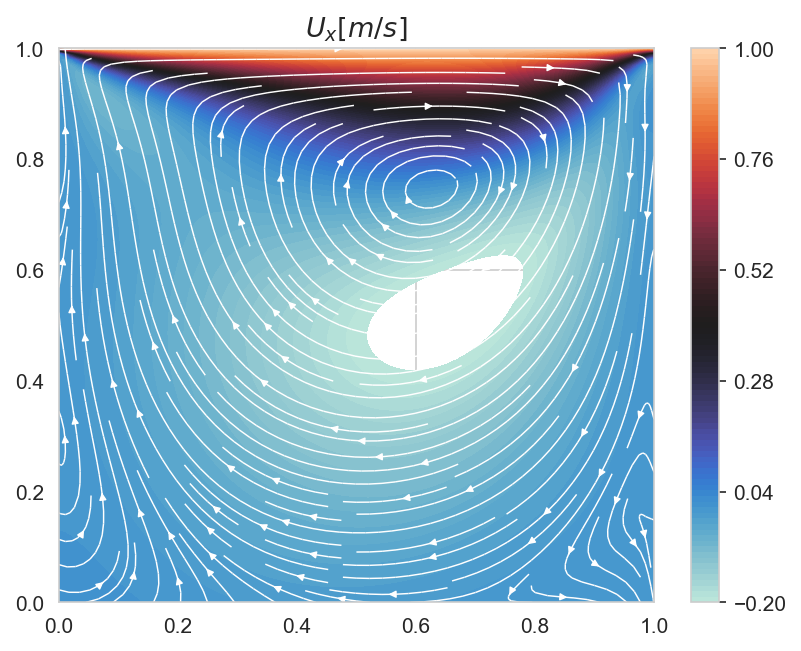

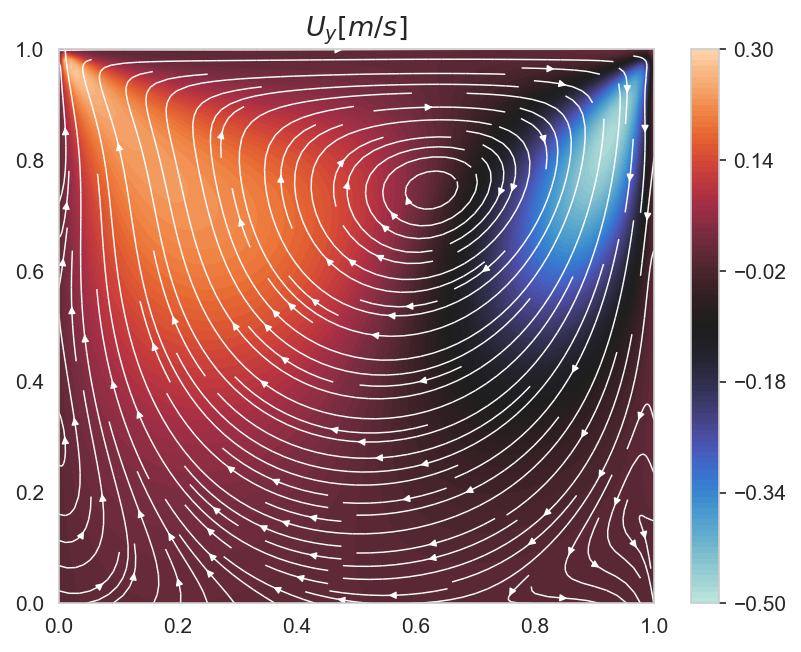

In [322]:

x1_test = np.linspace(bbox[0], bbox[1], 101)
x2_test = np.linspace(bbox[2], bbox[3], 102)
X_test = np.zeros((len(x1_test)*len(x2_test), 2))
X_test[:, 0] = np.vstack((x1_test,)*len(x2_test)).reshape(-1)
X_test[:, 1] = np.vstack((x2_test,)*len(x1_test)).T.reshape(-1)
Y_test = model.predict(X_test)
Y_test_VA = model_VA.predict(X_test)


plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test[:,0], y2=Y_test[:,1], tag='Vanilla', stream=True)
# plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test[:,0], y2=Y_test[:,1], tag='Vanilla', stream=False)
# plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test_VA[:,0], y2=Y_test_VA[:,1], tag='VA', stream=True)
# plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test_VA[:,0], y2=Y_test_VA[:,1], tag='VA', stream=False)

In [396]:
compile_kwargs = {"optimizer":"adam", "lr":1e-3}
print(**compile_kwargs)

TypeError: 'optimizer' is an invalid keyword argument for print()

In [267]:
# asdf =
# asdf = dde.Model(data_VA, net_VA)
model_VA.restore("./-25000.pt")
print(model_VA.predict(X_test))

[[ 4.8378110e-03  2.5187060e-03  3.0998936e+00]
 [ 5.4090321e-03  3.5374314e-03  3.0996742e+00]
 [ 5.8720112e-03  4.4099241e-03  3.0994694e+00]
 ...
 [ 9.9005276e-01 -6.1481372e-03  4.0657406e+00]
 [ 9.8459846e-01 -1.2945704e-02  4.4427376e+00]
 [ 1.0119693e+00  2.6617602e-02  5.0795398e+00]]
